In [1]:
%cd /home/jonahfoong/code/jonfoong/project-week/LW_chicago_crime_pred

/home/jonahfoong/code/jonfoong/project-week/LW_chicago_crime_pred


/home/jonahfoong/.pyenv/versions/chicago_crimes/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import sys
sys.path.append('/home/jonahfoong/code/jonfoong/project-week/LW_chicago_crime_pred')

In [3]:
from chicago_crime.ml_logic.extract import load_raw_data, load_postproc_data

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = load_postproc_data()

✅ Loaded 664125 rows from GCloud.post_proc



**NN model:**

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping

2024-09-03 09:42:49.845985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# DATA PREPROCESS

# parameters
sequence_length = 365  # number of days to consider for predicting the next day

# check num of communities
n_com = len(set(df.community_area))

In [9]:
X_test_list = []
X_test_scaled_list = []
y_test_list = []
X_train_list = []
y_train_list = []
X_val_list = []
y_val_list = []

In [10]:
areas = np.sort([int(i) for i in df.community_area.unique()])

In [ ]:
for area in areas:
    df_com = df.query(f"community_area=='{str(area)}'")

    # turn crimes into list
    crime_count_list = list(df_com["crime_count"])

    # create sequences
    X, y = [], []
    for i in range(sequence_length, len(crime_count_list)):
        X.append(crime_count_list[i-sequence_length:i])
        y.append(crime_count_list[i])

    X = np.array(X)
    y = np.array(y)

    # train_test_split
    train_rows = int(len(X) * 0.9)  # 90% for training

    X_train_full, X_test, y_train_full, y_test = X[:train_rows], X[train_rows:], y[:train_rows], y[train_rows:]

    # Further split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, shuffle = False)

    # scale
    scaler=MinMaxScaler().fit(X_train)
    X_train_scaled=scaler.transform(X_train)
    X_test_scaled=scaler.transform(X_test)
    X_val_scaled=scaler.transform(X_val)

    # append to lists

    X_test_scaled_list.append(X_test_scaled)
    X_test_list.append(X_test)
    y_test_list.append(y_test)
    X_train_list.append(X_train_scaled)
    y_train_list.append(y_train)
    X_val_list.append(X_val_scaled)
    y_val_list.append(y_val)

In [13]:
X_test_scaled = np.array(X_test_scaled_list).transpose(1, 2, 0)
X_test = np.array(X_test_list).transpose(1, 2, 0)
y_test = np.array(y_test_list).T
X_train = np.array(X_train_list).transpose(1, 2, 0)
y_train = np.array(y_train_list).T
X_val = np.array(X_val_list).transpose(1, 2, 0)
y_val = np.array(y_val_list).T

In [14]:
# NN Architecture

model = Sequential()

model.add(layers.GRU(units=32, activation='relu', input_shape=(sequence_length, n_com), return_sequences=True))
model.add(layers.GRU(units=32, activation='relu', return_sequences=True))
model.add(layers.GRU(units=16, activation='relu', return_sequences=True))
model.add(layers.GRU(units=8, activation='relu'))

model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(77, activation="linear"))

2024-09-02 17:35:39.507490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# Compilation

model.compile(loss='mae',
              optimizer=Adam(learning_rate=0.0005))

# Fit
es = EarlyStopping(patience=3)

history=model.fit(X_train, y_train, epochs=5, verbose=1, batch_size= 16 ,validation_data=(X_val,y_val)
                  , callbacks=[es]
                 )

Epoch 1/5


2024-09-02 17:35:45.953114: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 13375824 exceeds 10% of free system memory.


388/388 [==============================] - 18s 27ms/step - loss: 3.4468 - val_loss: 1.0623
Epoch 2/5
388/388 [==============================] - 10s 26ms/step - loss: 0.3549 - val_loss: 0.5498
Epoch 3/5
388/388 [==============================] - 10s 25ms/step - loss: 0.2737 - val_loss: 0.4993
Epoch 4/5
388/388 [==============================] - 10s 26ms/step - loss: 0.2659 - val_loss: 0.4791
Epoch 5/5
388/388 [==============================] - 10s 25ms/step - loss: 0.2616 - val_loss: 0.5449


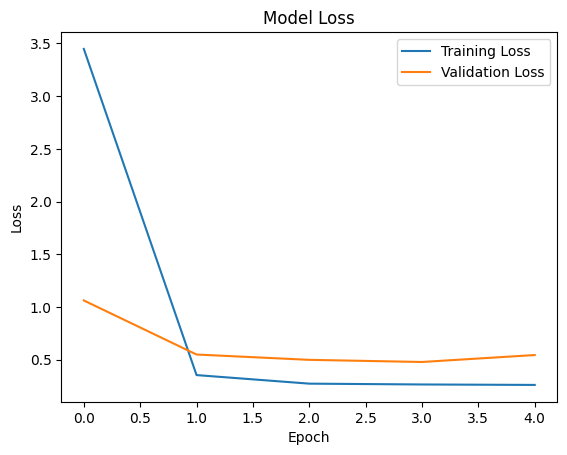

In [16]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [17]:
y_pred=model.predict(X_test_scaled)

27/27 [==============================] - 1s 9ms/step


In [18]:
mean_absolute_error(y_test, y_pred)

1.7313898092679476

In [19]:
y_hat = X_test[:, -1, :]
mean_absolute_error(y_test, y_hat)

0.043239822822189404

In [22]:
X_test.shape

(862, 7, 77)